In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

import scqubits as scq
import qutip as qt

from PulseSequence import PulseSequence
from QSwitch import QSwitch

style.use('default')
plt.rcParams['figure.figsize'] = [9.7, 6]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# scq.settings.PROGRESSBAR_DISABLED = True

In [2]:
hbar = 1.054e-34
h = hbar*2*np.pi
qe = 1.602e-19
red_flux_quant = hbar/2/qe 

# Unit conversions
MHz = 10.0**(-3)
GHz = 1.0
kHz = 10.0**(-6)
us = 10.0**3
ns = 1.0

# Set qubit parameters

In [36]:
# q_in, q_switch, q_out1, q_out2

# EJs = [13.41, 12.52, 8.94, 12.52]
# EJs = [12.109, 11.195, 7.997, 11.195]
EJs = [17.523, 16.450, 11.622, 16.450]

ECs = [0.237, 0.133, 0.270, 0.215]

# gs = [0.0827, 0.0787, 0.0652] # g12, g23, g24
# gs = [1e-3*73.44448637160531, 1e-3*70.62005211780702, 1e-3*58.4998799537415]
gs = [1e-3*88.68898701296644, 1e-3*85.3693409331001, 1e-3*70.91300299056793]
# gs = [1e-3*66.56542672271766, 1e-3*65.06457214018066, 1e-3*51.68752851908644]
# gs = [0.0613, 0.0600, 0.0475] # g12, g23, g24

# Analytical swap

In [41]:
cutoffs = [4, 5, 4, 4]
isCavity = [False, False, False, False]

qram = QSwitch(
    EJs=EJs,
    ECs=ECs,
    gs=gs,
    cutoffs=cutoffs,
    isCavity=isCavity,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print('qubit freqs (GHz)', *qubit_freqs)
print('alphas (GHz)', *alphas)
print('aprox sideband freqs (GHz)', 2*qubit_freqs[1] + alphas[1] - qubit_freqs)


print('capacitances (fF)', *(qe**2/(2*h*np.array(ECs)*1e9)*1e15))
print('lumped L (nH)', *(red_flux_quant**2/h/np.array(EJs)))

qubit freqs (GHz) 5.516003655258508 4.046006468928054 4.723218657577194 5.0944333073024985
alphas (GHz) -0.2642805948001996 -0.14418232920916196 -0.31503193753351333 -0.23921939266583792
aprox sideband freqs (GHz) [2.43182695 3.90182414 3.22461195 2.8533973 ]
capacitances (fF) 81.75723636114232 145.6877068991784 71.76468525033603 90.12309310507315
lumped L (nH) 9.32539564965757 9.933672216957424 14.060308722160524 9.933672216957424


In [38]:
# MAKE SURE DRESSED STATES ARE MAPPED CORRECTLY, AT LEAST FOR <= n EXCITATIONS
# qram.check_state_mapping(n=3)

## Create pulse sequence

In [39]:
seq = PulseSequence(start_time=0)
# wd1 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.17)
# wd2 = qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.01)
# wd3 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.08)
# wd4 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', wd=wd1, amp=0.17)
# wd5 = qram.add_sequential_pi_pulse(seq, 'ggeg', 'geeg', amp=0.01) # should be same as wd2
# wd6 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.01)
# wd7 = qram.add_sequential_pi_pulse(seq, 'ggge', 'gege', amp=0.01) # should be same as wd2 and should also drive geeg -> ggeg


print('wd1')
wd1 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.10, drive_qubit=1)
print('wd2')
wd2 = qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.01, drive_qubit=1)
print('wd3')
wd3 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.05, drive_qubit=1)
print('wd4')
wd4 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.10, drive_qubit=1, wd=wd1)
# wd4 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.05, drive_qubit=0, wd=wd1)
print('wd5')
wd5 = qram.add_sequential_pi_pulse(seq, 'ggeg', 'geeg', amp=0.01, drive_qubit=1)
print('wd6')
wd6 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.10, drive_qubit=1)
print('wd7')
wd7 = qram.add_sequential_pi_pulse(seq, 'ggge', 'gege', amp=0.01, drive_qubit=1)
print('wd8')
wd8 = qram.add_sequential_pi_pulse(seq, 'geeg', 'ggeg', amp=0.01, drive_qubit=1)

# wd7_1 = qram.get_wd('ggge', 'gege', amp=0.01, drive_qubit=1, verbose=True)
# wd7_2 = qram.get_wd('geeg', 'ggeg', amp=0.01, drive_qubit=1, verbose=True)
# wd7 = qram.add_sequential_pi_pulse(seq, 'ggge', 'gege', amp=0.01, 
#                                    drive_qubit=1, wd=np.average((wd7_1, wd7_2)))
print('Done.')

wd1
	new overlap 0.8696243493579651 wd 15.02309183798259 wd_res 0.25
	new overlap 0.8696243493579651 wd 15.02309183798259 wd_res 0.05
	new overlap 0.988116201845584 wd 15.01809183798259 wd_res 0.005
	new overlap 0.9961918246744771 wd 15.01909183798259 wd_res 0.001
updated drive freq (GHz) from 2.3909993265384366 to 2.390362706766069
wd2
	new overlap 0.9983831623050176 wd 25.273599869823087 wd_res 0.25
updated drive freq (GHz) from 4.022418349009027 to 4.022418349009027
wd3
	new overlap 0.928462965886794 wd 19.97392106767524 wd_res 0.25
	new overlap 0.928462965886794 wd 19.97392106767524 wd_res 0.05
	new overlap 0.9954758854616184 wd 19.96892106767524 wd_res 0.005
updated drive freq (GHz) from 3.178948270847862 to 3.1781524961324026
wd4
wd5
	new overlap 0.9981478733337341 wd 25.173850824431273 wd_res 0.25
updated drive freq (GHz) from 4.006542795366222 to 4.006542795366222
wd6
	new overlap 0.8144640672238908 wd 17.675860696368815 wd_res 0.25
	new overlap 0.8144640672238908 wd 17.6758606

In [7]:
# CHECK FOR CLASHING LEVELS
tolerance = 100*MHz
problem_pulses = qram.check_level_resonances(seq, tolerance=tolerance)
good_freqs = seq.get_pulse_freqs(simplified=True)
print(good_freqs)
if len(problem_pulses.items()) == 0:
    print(f'No clashes found within {tolerance} GHz!')
for good_pulse, problem_pulse_dict in problem_pulses.items():
    print('Clashes to', tolerance,'GHz with', good_pulse[0], '<->', good_pulse[1], f'(freq = {good_freqs[good_pulse]})', 'tpi', qram.get_Tpi(good_pulse[0], good_pulse[1], amp=0.05))
    for problem_pulse, freq in problem_pulse_dict.items():
        diff_freq = np.abs(freq)-np.abs(good_freqs[good_pulse])
        if np.abs(diff_freq) > tolerance:
            diff_freq = 2*np.abs(freq)-np.abs(good_freqs[good_pulse])
        print('\t', 'GOOD PULSE' if problem_pulse in good_freqs.keys() else '', problem_pulse[0], '<->', problem_pulse[1], freq, f'(off by {diff_freq*1e3} MHz)', 'tpi', qram.get_Tpi(problem_pulse[0], problem_pulse[1], amp=0.05))

{('eggg', 'gfgg'): 2.0518716263123307, ('eegg', 'eggg'): 3.4923978202179504, ('gfgg', 'ggeg'): 2.735919711187969, ('geeg', 'ggeg'): 3.4753950829028497, ('gfgg', 'ggge'): 2.429755618428295, ('gege', 'ggge'): 3.494625787443039}
Clashes to 0.1 GHz with eegg <-> eggg (freq = 3.4923978202179504) tpi 10.121187417445148
	 GOOD PULSE geeg <-> ggeg 3.4753950829028497 (off by -17.002737315100713 MHz) tpi 10.519131958865753
	 GOOD PULSE gege <-> ggge 3.494625787443039 (off by 2.2279672250884452 MHz) tpi 10.160446702054998
Clashes to 0.1 GHz with geeg <-> ggeg (freq = 3.4753950829028497) tpi 10.519131958865753
	 GOOD PULSE eegg <-> eggg 3.4923978202179504 (off by 17.002737315100713 MHz) tpi 10.121187417445148
	 GOOD PULSE gege <-> ggge 3.494625787443039 (off by 19.23070454018916 MHz) tpi 10.160446702054998
Clashes to 0.1 GHz with gege <-> ggge (freq = 3.494625787443039) tpi 10.160446702054998
	 GOOD PULSE eegg <-> eggg 3.4923978202179504 (off by -2.2279672250884452 MHz) tpi 10.121187417445148
	 GO

[2.0518716263123307, 3.4923978202179504, 2.735919711187969, 2.0518716263123307, 3.4753950829028497, 2.429755618428295, 3.494625787443039, 3.4753950829028497] (GHz)
[618.8932706085322, 50.60593708722573, 336.86349632588247, 618.8932706085322, 52.59565979432877, 409.4318183476376, 50.80223351027498, 52.59565979432877] (ns)
total pulse length 2190.681346076743 ns


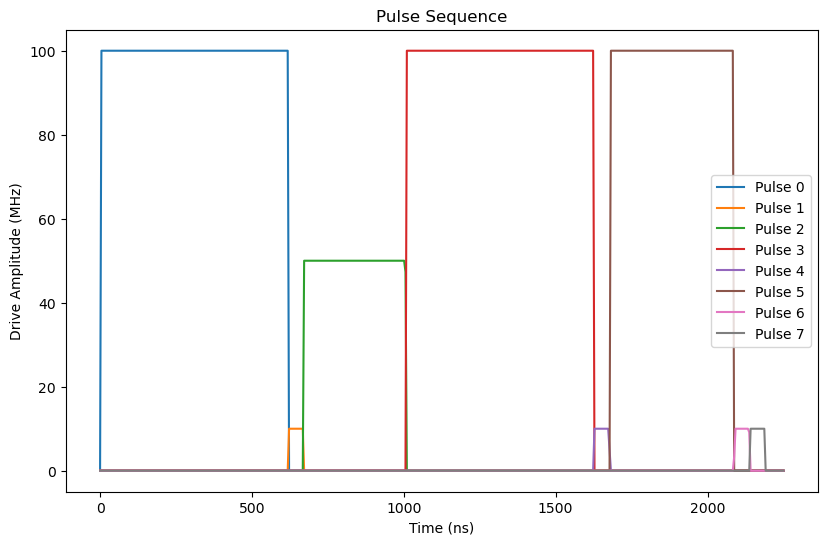

In [8]:
# times = np.linspace(0, 26000, 1000)
times = np.linspace(0, 2250, 500)
# times = np.linspace(0, 300, 700)
# times = np.linspace(0, 50, 100)

envelope_seq = seq.get_envelope_seq()
pulse_amps = seq.get_pulse_amps()
print(seq.get_pulse_freqs(), '(GHz)')
print(seq.get_pulse_lengths(), '(ns)')
print('total pulse length', sum(seq.get_pulse_lengths()), 'ns')
for i in range(len(envelope_seq)):
    plt.plot(times, [pulse_amps[i]*envelope_seq[i](t)/MHz for t in times], label=f'Pulse {i}')
plt.xlabel('Time (ns)')
plt.ylabel('Drive Amplitude (MHz)')
plt.title('Pulse Sequence')
plt.legend()
plt.show()

## Run simulation

In [9]:
T1 = 60e3 # ns
T2 = 30e3 # ?

# T1 = 10e3

# c_ops = [
#     np.sqrt(1/T1)*qram.a,
#     np.sqrt(1/T1)*qram.b,
#     np.sqrt(1/T1)*qram.c,
#     np.sqrt(1/T1)*qram.d,
# ]

c_ops = None

In [10]:
# psi0_name = 'eggg'
# psi0_name = 'gfgg'
# psi0_name = 'efgg'
# psi0_name = 'eegg'
# psi0_name = 'ggeg'
# psi0_name = 'ggge'

# psi0 = qram.state(psi0_name)
psi0 = np.sqrt(0.4) * qram.state('eggg') + np.sqrt(0.6) * qram.state('eegg') # QRAM start
# psi0 = np.sqrt(0.4) * qram.state('gggg') + np.sqrt(0.6) * qram.state('gegg') # QRAM start

# print(seq.get_pulse_str())

result = qram.evolve(psi0, seq, times, c_ops=None, nsteps=10000, use_str_solve=False)
# result = qram.evolve_rot_frame(psi0, seq, times, c_ops=None, nsteps=20000)

10.0%. Run time:  37.80s. Est. time left: 00:00:05:40
20.0%. Run time:  74.13s. Est. time left: 00:00:04:56
30.0%. Run time: 111.24s. Est. time left: 00:00:04:19
40.0%. Run time: 147.76s. Est. time left: 00:00:03:41
50.0%. Run time: 184.61s. Est. time left: 00:00:03:04
60.0%. Run time: 221.02s. Est. time left: 00:00:02:27
70.0%. Run time: 258.43s. Est. time left: 00:00:01:50
80.0%. Run time: 295.50s. Est. time left: 00:00:01:13
90.0%. Run time: 332.69s. Est. time left: 00:00:00:36
Total run time: 372.05s


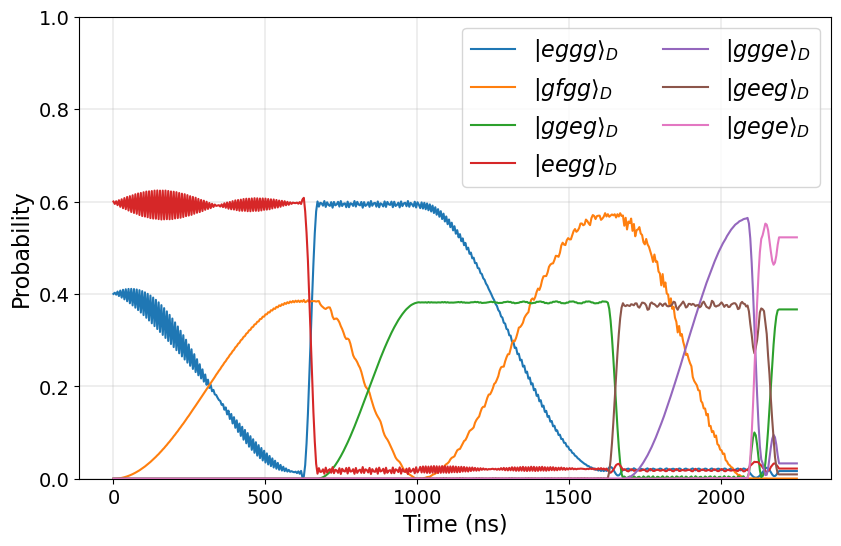

In [32]:
# states for 1 input
eggg = qram.state('eggg')
gfgg = qram.state('gfgg')
ggeg = qram.state('ggeg')
eegg = qram.state('eegg')
ggge = qram.state('ggge')
geeg = qram.state('geeg')
gege = qram.state('gege')
prob_eggg = [np.abs(eggg.overlap(result[t]))**2 for t in range(len(times))]
prob_gfgg = [np.abs(gfgg.overlap(result[t]))**2 for t in range(len(times))]
prob_ggeg = [np.abs(ggeg.overlap(result[t]))**2 for t in range(len(times))]
prob_eegg = [np.abs(eegg.overlap(result[t]))**2 for t in range(len(times))]
prob_ggge = [np.abs(ggge.overlap(result[t]))**2 for t in range(len(times))]
prob_geeg = [np.abs(geeg.overlap(result[t]))**2 for t in range(len(times))]
prob_gege = [np.abs(gege.overlap(result[t]))**2 for t in range(len(times))]

# states for 0 input
gggg = qram.state('gggg')
gegg = qram.state('gegg')
prob_gggg = [np.abs(gggg.overlap(result[t]))**2 for t in range(len(times))]
prob_gegg = [np.abs(gegg.overlap(result[t]))**2 for t in range(len(times))]


plt.plot(times, prob_eggg, label=r'$|eggg\rangle_D$')
plt.plot(times, prob_gfgg, label=r'$|gfgg\rangle_D$')
plt.plot(times, prob_ggeg, label=r'$|ggeg\rangle_D$')
plt.plot(times, prob_eegg, label=r'$|eegg\rangle_D$')
plt.plot(times, prob_ggge, label=r'$|ggge\rangle_D$')
plt.plot(times, prob_geeg, label=r'$|geeg\rangle_D$')
plt.plot(times, prob_gege, label=r'$|gege\rangle_D$')

# plt.plot(times, prob_gggg, label=r'$|gggg\rangle_D$')
# plt.plot(times, prob_gegg, label=r'$|gegg\rangle_D$')

# plt.plot(times, [np.abs(state('geeg').overlap(result[t]))**2 for t in range(len(times))], 'k--', label=r'$|geeg\rangle_D$')
# plt.plot(times, [np.abs(state('efgg').overlap(result[t]))**2 for t in range(len(times))], 'k-.', label=r'$|efgg\rangle_D$')

# for i1 in range(cutoffs[0]):
#     for i2 in range(cutoffs[1]):
#         for i3 in range(cutoffs[2]):
#             for i4 in range(cutoffs[3]):
#                 # print(qram.levels_nums_to_name([i1, i2, i3, i4]))
#                 plt.plot(times, 
#                          [np.abs(qram.state([i1, i2, i3, i4]).overlap(result[t]))**2 for t in range(len(times))],
#                          label='qram.level_nums_to_name[i1, i2, i3, i4]')

# plt.plot(times, [0.5]*len(times), 'k--', linewidth=0.5)
plt.legend(fontsize=16, ncol=2)
plt.ylim(0, 1)
# plt.xlim(750, 1000)
plt.tick_params(labelsize=14)
plt.xlabel('Time (ns)', fontsize=16)
plt.ylabel('Probability', fontsize=16)
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)
plt.show()

Max fidelity [%]: 88.73741112694961
Final fidelity [%]: 3.7570170941005196


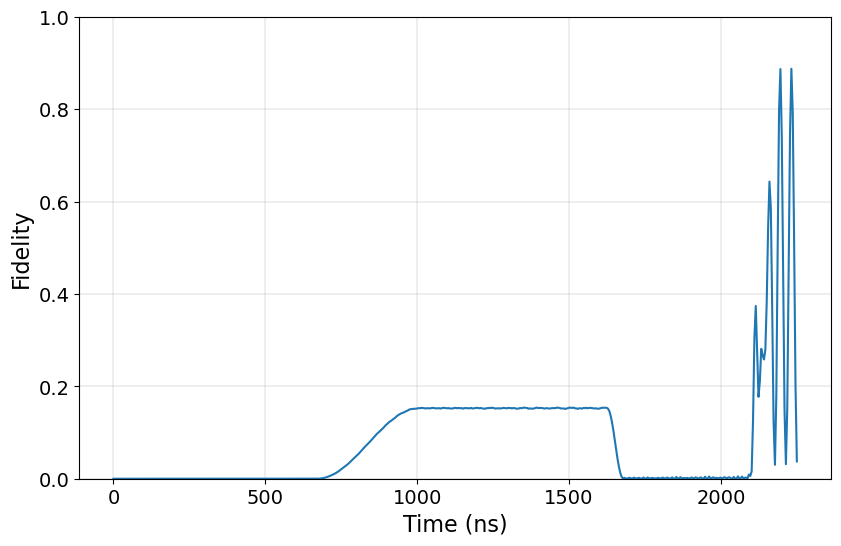

In [35]:
# ket_target = qram.state('ggeg')
ket_target = np.sqrt(0.4) * qram.state('ggeg') + np.sqrt(0.6) * qram.state('gege')
qram.fidelity(qram.state('ggeg'), result[-1])
qram.fidelity(qram.state('gege'), result[-1])

fidelities = [qram.fidelity(ket_target, result[t]) for t in range(len(times))]
print(f'Max fidelity [%]: {1e2*max(fidelities)}')
print(f'Final fidelity [%]: {1e2*fidelities[-1]}')

plt.plot(times, fidelities)

# plt.legend(fontsize=16, ncol=2)
plt.ylim(0, 1)
# plt.xlim(750, 1000)
plt.tick_params(labelsize=14)
plt.xlabel('Time (ns)', fontsize=16)
plt.ylabel('Fidelity', fontsize=16)
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)
plt.show()

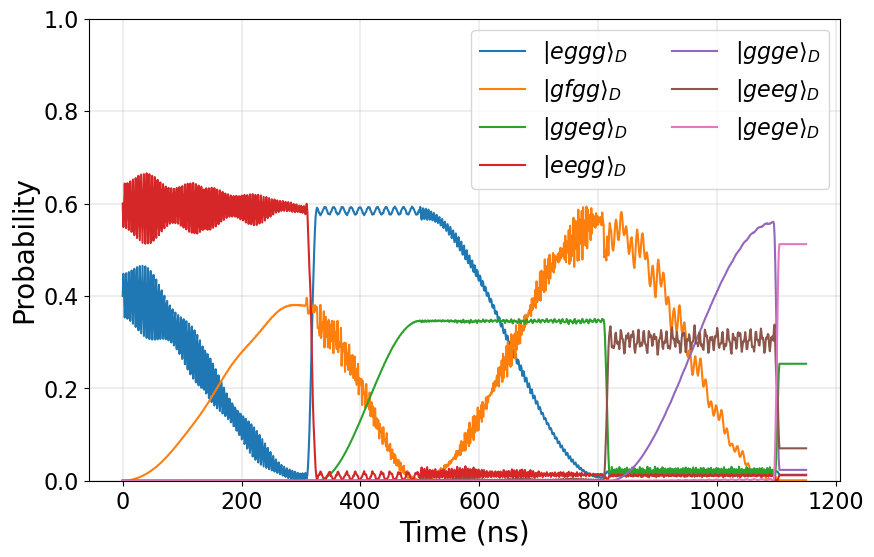

In [15]:
# states for 1 input
eggg = qram.state('eggg')
gfgg = qram.state('gfgg')
ggeg = qram.state('ggeg')
eegg = qram.state('eegg')
ggge = qram.state('ggge')
geeg = qram.state('geeg')
gege = qram.state('gege')
prob_eggg = [np.abs(eggg.overlap(result[t]))**2 for t in range(len(times))]
prob_gfgg = [np.abs(gfgg.overlap(result[t]))**2 for t in range(len(times))]
prob_ggeg = [np.abs(ggeg.overlap(result[t]))**2 for t in range(len(times))]
prob_eegg = [np.abs(eegg.overlap(result[t]))**2 for t in range(len(times))]
prob_ggge = [np.abs(ggge.overlap(result[t]))**2 for t in range(len(times))]
prob_geeg = [np.abs(geeg.overlap(result[t]))**2 for t in range(len(times))]
prob_gege = [np.abs(gege.overlap(result[t]))**2 for t in range(len(times))]

# states for 0 input
gggg = qram.state('gggg')
gegg = qram.state('gegg')
prob_gggg = [np.abs(gggg.overlap(result[t]))**2 for t in range(len(times))]
prob_gegg = [np.abs(gegg.overlap(result[t]))**2 for t in range(len(times))]


plt.plot(times, prob_eggg, label=r'$|eggg\rangle_D$')
plt.plot(times, prob_gfgg, label=r'$|gfgg\rangle_D$')
plt.plot(times, prob_ggeg, label=r'$|ggeg\rangle_D$')
plt.plot(times, prob_eegg, label=r'$|eegg\rangle_D$')
plt.plot(times, prob_ggge, label=r'$|ggge\rangle_D$')
plt.plot(times, prob_geeg, label=r'$|geeg\rangle_D$')
plt.plot(times, prob_gege, label=r'$|gege\rangle_D$')

# plt.plot(times, prob_gggg, label=r'$|gggg\rangle_D$')
# plt.plot(times, prob_gegg, label=r'$|gegg\rangle_D$')

# plt.plot(times, [np.abs(state('geeg').overlap(result[t]))**2 for t in range(len(times))], 'k--', label=r'$|geeg\rangle_D$')
# plt.plot(times, [np.abs(state('efgg').overlap(result[t]))**2 for t in range(len(times))], 'k-.', label=r'$|efgg\rangle_D$')

# for i1 in range(cutoffs[0]):
#     for i2 in range(cutoffs[1]):
#         for i3 in range(cutoffs[2]):
#             for i4 in range(cutoffs[3]):
#                 # print(qram.levels_nums_to_name([i1, i2, i3, i4]))
#                 plt.plot(times, 
#                          [np.abs(qram.state([i1, i2, i3, i4]).overlap(result[t]))**2 for t in range(len(times))],
#                          label='qram.level_nums_to_name[i1, i2, i3, i4]')

# plt.plot(times, [0.5]*len(times), 'k--', linewidth=0.5)
plt.legend(fontsize=16, ncol=2)
plt.ylim(0, 1)
# plt.xlim(750, 1000)
plt.tick_params(labelsize=14)
plt.xlabel('Time (ns)', fontsize=16)
plt.ylabel('Probability', fontsize=16)
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)
plt.show()

In [11]:
T = 30 # ns

sum_psi = 0
T = np.argmin(np.abs(times-T))
probs = dict()
print("Non-zero levels:")
for i1 in range(cutoffs[0]):
    for i2 in range(cutoffs[1]):
        for i3 in range(cutoffs[2]):
            for i4 in range(cutoffs[3]):
                prob = np.abs(qram.state([i1, i2, i3, i4]).overlap(result[T]))**2
                sum_psi += prob
                if prob > 0.01:
                    probs.update({qram.level_nums_to_name([i1, i2, i3, i4]):prob})
probs = sorted(probs.items(), key=lambda item:-item[1])
for level, prob in probs:
    print(level, prob)
print('Sum probabilities:', sum_psi)

Non-zero levels:
eegg 0.5658559845150481
eggg 0.42112663979577264
Sum probabilities: 1.0


In [12]:
print('want', qram.get_base_wd('eggg', 'gfgg')/2/np.pi)
print('want', qram.get_base_wd('eegg', 'eggg')/2/np.pi)
# print('want', qram.get_wd('eggg', 'gfgg', 0.10, verbose=False)/2/np.pi)
# print('want', qram.get_wd('eegg', 'gfgg', 0.10, verbose=False)/2/np.pi)
# print('want', qram.get_wd('ggge', 'gege', 0.05, verbose=False)/2/np.pi)
# print('resonant to', qram.get_wd('ggeg', 'geeg', 0.05)/2/np.pi)
# print('2 photon transition to', qram.get_base_wd('eggg', 'efgg')/2/np.pi)

want 2.1692639480132065
want 3.6869102975757024
